In [11]:
#Preprocessing
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
import h5py
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib_venn import venn3, venn3_circles
import pickle
import gzip
import pandas as pd
import requests
import math
import pdb
import time
import os
import matplotlib.patches as mpatches
%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
from scipy.misc import imresize

tissue_types = ['Lung', 'Artery - Tibial', 'Heart - Left Ventricle', 'Breast - Mammary Tissue', 'Brain - Cerebellum', 'Pancreas', 'Testis', 'Liver', 'Ovary', 'Stomach']
genotypes_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/GenotypeFiles/phg000520.v2.GTEx_MidPoint_Imputation.genotype-calls-vcf.c1/parse_data/GTEx_Analysis_20150112_OMNI_2.5M_5M_450Indiv_chr1to22_genot_imput_info04_maf01_HWEp1E6_ConstrVarIDs_all_chrom_filered_maf_subset_individuals_44_tissues.hdf5'
expression_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/ExpressionFiles/phe000006.v2.GTEx_RNAseq.expression-data-matrixfmt.c1/parse_data/44_tissues/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm_*_normalised_without_inverse_gene_expression.txt'
phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
lung_expression_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/ExpressionFiles/phe000006.v2.GTEx_RNAseq.expression-data-matrixfmt.c1/parse_data/44_tissues/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm_{}_normalised_without_inverse_gene_expression.txt'.format("Lung")

GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'

def build_empty_model():
    inception_model = InceptionV3(weights='imagenet', include_top=False)

    x = inception_model.output

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(input=inception_model.input, output=predictions)
    return model

def get_donor_IDs(IDlist):
    return [str(x).split('-')[1] for x in IDlist]

def sigmoid(x):
    return 1 / (1 + np.exp(-np.array(x)))

model = build_empty_model()
model.load_weights(GTEx_directory + '/models/inception_50_-1_gs1.h5')
final_layer_model = Model(model.input, model.layers[-2].output)

ID = 'GTEX-133LE-0526'
patches = pickle.load(open(GTEx_directory + '/data/processed/covering_patches/{}/{}/{}/{}'.format('medium','Lung',ID,'GTEX-133LE-0526_16000'), 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/hps/nobackup/research/stegle/users/willj/GTEx/data/processed/covering_patches/medium/Lung/GTEX-133LE-0526/GTEX-133LE-0526_16000'

In [22]:
patches = pickle.load(open(GTEx_directory + '/data/processed/covering_patches/{}/{}/{}/{}'.format('medium','Lung',ID,'GTEX-133LE-0526_4000'), 'rb'))

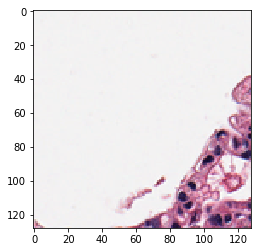

In [53]:
plt.imshow(patches[107])

In [ ]:
final_layer_model.layers[3].output[:,:,:,1]

In [ ]:
plt.imshow(patches[0])

In [55]:
def process_image(image):
    image = image.astype(np.float32)
    image = imresize(image, (299,299,3))
    image = np.expand_dims(image,0) / 255
    return image

In [111]:
def maximise_ith_component(image, model, component, steps):
    print ('generating iteration function')
    # build a loss function that maximizes the activation of the ith filter 
    input_img = model.layers[0].input
    layer_output = model.layers[3].output
    loss = K.mean(layer_output[:,:,:,component])
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]
    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])
    
    print ('performing gradient ascent')
    example_image = process_image(image)
    input_img_data = example_image.copy()
    original_img_data = example_image.copy()
    step = 1.
    for i in range(steps):
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data += grads_value * step
        if i % 500 == 0:
            print (i, loss_value)
    
    f,a = plt.subplots(1,2, figsize=(15,5))
    f.suptitle("Component {}".format(component))
    a[0].imshow(np.squeeze(input_img_data))
    a[0].set_title("Modified")
    a[1].imshow(np.squeeze(original_img_data))
    a[1].set_title("Original")

In [70]:
noise_image = np.random.randint(0,255,size=[128,128,3])

generating iteration function
performing gradient ascent
0 2.41007
500 8963.57
1000 17966.8
1500 26970.9
2000 35974.7
2500 44979.1
3000 53984.1
3500 62988.8
4000 71993.4
4500 80998.4


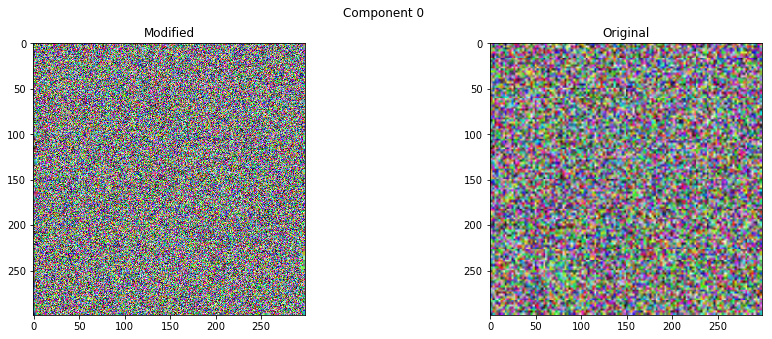

In [114]:
maximise_ith_component(noise_image,final_layer_model, 0, 5000)

# There doesn't seem to be anything useful even on early filters

# What about when using the raw InceptioNet and not my trained model?

## Raw InceptionNet

In [72]:
inception_model = InceptionV3(weights='imagenet')

generating iteration function
performing gradient ascent
0 1.39388
500 25.84
1000 47.8493
1500 70.1329


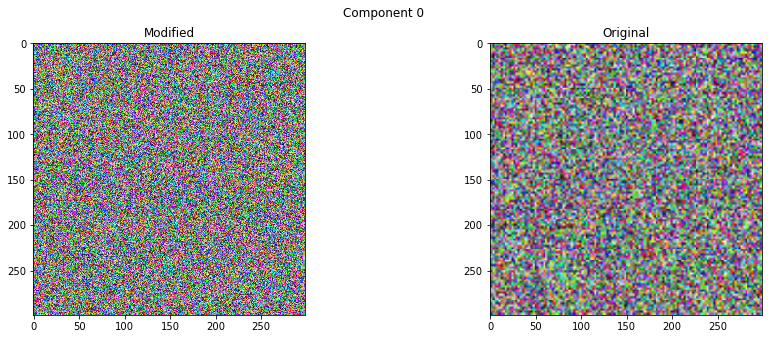

In [74]:
maximise_ith_component(noise_image, inception_model,0, 2000) 

## Raw VGG

In [76]:
from keras import applications

# build the VGG16 network
vgg_model = applications.VGG16(include_top=False,weights='imagenet')

generating iteration function
performing gradient ascent
0 3.38395
500 118.972
1000 234.571
1500 350.506


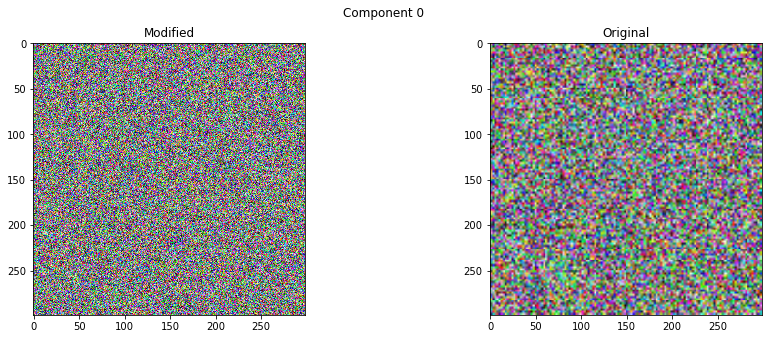

In [77]:
maximise_ith_component(noise_image, vgg_model,0, 2000) 

# From my previous code

[1, None, None, 64]


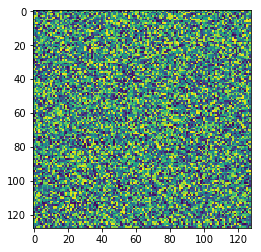

In [98]:
def generate_maximal_activations(model,layer_index):
    
    layer = model.layers[layer_index]
    img_shape = [1] + layer.get_input_at(0).get_shape().as_list()[1:]
    print (img_shape)
    nb_filters = layer.get_output_at(0).get_shape().as_list()[-1]

    input_img = layer.get_input_at(0)
    layer_output = model.layers[layer_index].get_output_at(0)
    k = int(math.sqrt(nb_filters))
    loss = K.mean(layer_output[:, :, :, 5])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random([1, 128, 128, 64])
    # run gradient ascent for 20 steps
    for i in range(50):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * 10

    return np.squeeze(input_img_data)[:,:,0]

plt.imshow(generate_maximal_activations(vgg_model,3))

# Using code from Keras blog

In [102]:
from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
#     if K.image_data_format() == 'channels_first':
#         x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


kept_filters = []
for filter_index in range(0, 10):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise

    input_img_data = np.random.random((1, img_width, img_height, 3))

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Model loaded.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, None, None, 64 1792        input_11[0][0]                   
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, None, None, 64 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, None, None, 64 0           block1_conv2[0][0]               
_____________________________________________________________________________

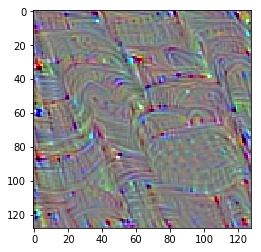

In [124]:
plt.imshow(kept_filters[8][0])